In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist

In [ ]:
import tempfile
!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

     |████████████████████████████████| 174kB 12.8MB/s 


#Training MNIST

In [ ]:
mnist_data = mnist.load_data()
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = np.reshape(X_train, (60000, 28, 28, 1))
X_test = np.reshape (X_test, (10000, 28, 28, 1))

Y_train = np.eye(10)[Y_train]
Y_test = np.eye(10)[Y_test]

11493376/11490434 [==============================] - 0s 0us/step


label: 4


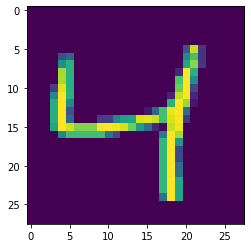

In [ ]:
def display_image (image_matrix):
  plt.imshow(np.reshape(image_matrix[:][:], (28, 28)))
def display_label (label_onehot):
  print(np.where(label_onehot==1)[0].item(0))
  
print ("label: ", end="")
display_label(Y_train[2])
display_image(X_train[2])

In [ ]:
X_input = tf.keras.Input((28, 28, 1), name='input')

X = tf.keras.layers.Conv2D(8, (3, 3), name='conv1', activation='relu')(X_input)
X = tf.keras.layers.Conv2D(8, (3, 3), name='conv2', activation='relu')(X)

X = tf.keras.layers.Flatten(name='flatten')(X)
X = tf.keras.layers.Dense(32, name='dense1', activation="relu")(X)
X = tf.keras.layers.Dense(10, name='dense2', activation="softmax")(X)

model = tf.keras.Model(inputs = X_input, outputs = X, name='teacherModel')
model.compile (optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "teacherModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 8)         80        
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 8)         584       
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense1 (Dense)               (None, 32)                147488    
_________________________________________________________________
dense2 (Dense)               (None, 10)                330       
Total params: 148,482
Trainable params: 148,482
Non-trainable params: 0
________________________________________________

In [ ]:
model.fit (x=X_train, y=Y_train, epochs=3, validation_data=(X_test,Y_test))

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4066 - accuracy: 0.8852 - val_loss: 0.1218 - val_accuracy: 0.9630
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0824 - accuracy: 0.9755 - val_loss: 0.0860 - val_accuracy: 0.9732
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0544 - accuracy: 0.9831 - val_loss: 0.0881 - val_accuracy: 0.9748


In [ ]:
model.evaluate(x=X_test, y=Y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0881 - accuracy: 0.9748


[0.08814950287342072, 0.9747999906539917]

label: 0
prediction:  0


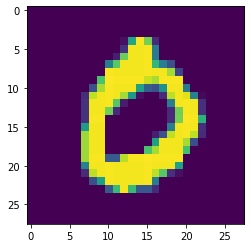

In [ ]:
print ("label: ", end="")

ind = 3
sample_image = X_test[ind]
sample_label = Y_test[ind]

display_label(sample_label)
print("prediction: ", np.argmax(model.predict(np.expand_dims(sample_image, axis=0))))
display_image(sample_image)

#Using Tensorflow functionality for weight-based magnitude pruning

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0]
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = { 'pruning_schedule': 
                  tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=0, end_step=end_step) }

model_for_pruning = prune_low_magnitude(tf.keras.models.clone_model(model), **pruning_params)

# 'prune_low_magnitude' requires a recompile.
model_for_pruning.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "teacherModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
prune_low_magnitude_conv1 (P (None, 26, 26, 8)         154       
_________________________________________________________________
prune_low_magnitude_conv2 (P (None, 24, 24, 8)         1162      
_________________________________________________________________
prune_low_magnitude_flatten  (None, 4608)              1         
_________________________________________________________________
prune_low_magnitude_dense1 ( (None, 32)                294946    
_________________________________________________________________
prune_low_magnitude_dense2 ( (None, 10)                652       
Total params: 296,915
Trainable params: 148,482

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [ tfmot.sparsity.keras.UpdatePruningStep(), tfmot.sparsity.keras.PruningSummaries(log_dir=logdir), ]

model_for_pruning.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, 
                      validation_data=(X_test,Y_test), callbacks=callbacks)

Epoch 1/2
  1/469 [..............................] - ETA: 0s - loss: 48.3491 - accuracy: 0.0547WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
469/469 [==============================] - 4s 9ms/step - loss: 1.5240 - accuracy: 0.5289 - val_loss: 1.2489 - val_accuracy: 0.5597
Epoch 2/2
469/469 [==============================] - 4s 8ms/step - loss: 1.1275 - accuracy: 0.5724 - val_loss: 1.0394 - val_accuracy: 0.6428


In [ ]:
epochs = 2

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

for epoch in range(epochs):
  print("Epoch #", epoch)

  for index in range(len(X_train), batch_size):
    batch_no = floor(index/batch_size)

    x_batch_train = X_train[index:index+batch_size]
    y_batch_train = Y_train[index:index+batch_size]
    
    with tf.GradientTape() as tape:
        logits = model(x_batch_train, training=True)
        loss_value = loss_fn(y_batch_train, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

Epoch # 0
Epoch # 1
